In [1]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from sklearn.externals.joblib import dump
#from sklearn.externals.joblib import load
#from sklearn.feature_selection import RFE

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

# Libraries for neural network
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
outlier_flag = True      # Will threshold the outliers to outlier_max_value value
outlier_max_value = 25000
scale_flag = True
scale_cols=['n_tokens_title','average_token_length']

In [3]:
# Display all columns in pandas
pd.set_option('display.max_columns', None)

### Reading data

In [4]:
inputFile = '../data/output/OnlineNewsPopularity_featureEngg_Lasso.csv' #Kannan stiched this file
df = read_csv(inputFile)
df.columns = df.columns.str.replace(' ','')
print(df.shape)
df.head()

(7795, 77)


,NMF_C1,NMF_C2,n_unique_tokens,NMF_C5,data_channel_is_world,data_channel_is_entertainment,data_channel_is_lifestyle,data_channel_is_bus,data_channel_is_tech,data_channel_is_socmed,NMF_C8,NMF_C6,n_non_stop_unique_tokens,n_non_stop_words,LDA_T8,NMF_C9,average_token_length,LDA_T0,LDA_C3,LDA_C7,LSI_T3,LSI_T1,LDA_T2,LDA_T5,LSI_T9,NMF_C7,LDA_C8,LDA_C5,LSI_C3,keywords_pca_8,LDA_T4,LDA_C4,NER_LANGUAGE,LSI_C2,is__Friday,LSI_T2,subjectivity_content,LSI_C1,is__Saturday,LDA_T1,is__Tuesday,LSI_T4,subjectivity_title,polarity_title,keywords_pca_2,LSI_C4,LSI_C8,NER_list_pca_8,is__Thursday,LDA_T6,num_keywords,is__Sunday,n_tokens_title,LSI_C9,LSI_T8,LSI_T5,NER_ORDINAL,LDA_C0,LDA_C6,LSI_C0,NER_LAW,keywords_pca_1,keywords_pca_6,LDA_C9,LSI_T6,LSI_C6,NER_LOC,LSI_T0,keywords_pca_7,keywords_pca_5,NER_list_pca_6,LSI_C7,NER_PRODUCT,NER_QUANTITY,Id,url,shares
0,0.000000,0.000000,0.661355,0.000000,1,0,0,0,0,0,0.000000,0.693804,0.787500,1.0,0.016667,0.000000,4.873563,0.016667,0.000246,0.000246,0.071074,0.008433,0.016667,0.016667,-0.000281,0.000000,0.043894,0.000246,0.619695,0.047081,0.016667,0.000246,0,-0.375391,0,0.022291,0.390972,-7.231903,0,0.016667,0,0.029553,0.00,0.000,-0.216242,0.516641,-0.904952,1.878684,0,0.016667,7,0,10,-5.292540,-0.122421,-0.002416,0,0.000246,0.930751,6.016982,0,1.098373,0.445485,0.000246,0.100828,8.468454,0,0.007747,0.087398,0.025333,-2.026706,1.266744,0,1,1,http://mashable.com/2014/09/01/americans-held-...,1100
1,0.025564,0.661792,0.370242,0.000000,0,0,0,0,0,0,0.000000,0.000000,0.535038,1.0,0.016667,1.186385,4.554439,0.683333,0.000353,0.000353,-0.069833,1.093901,0.016667,0.016667,-0.147228,0.000000,0.088030,0.000353,8.128548,-0.066772,0.016667,0.000353,0,11.003010,0,-0.090589,0.618573,0.786892,0,0.016667,0,-0.042007,0.00,0.000,-1.123091,4.545864,5.120845,-0.076752,0,0.183334,8,0,7,-6.994067,-0.068469,-0.009291,0,0.449703,0.000353,10.968958,0,-1.679171,-0.310026,0.000353,0.170685,-5.108536,0,0.201644,-0.153742,-0.676669,-0.929726,9.998898,0,0,2,http://mashable.com/2014/09/01/apple-visa-mast...,1100
2,0.003073,0.000000,0.524291,0.037288,1,0,0,0,0,0,0.000000,0.034266,0.704918,1.0,0.016667,0.058433,5.003976,0.016667,0.122848,0.146242,0.007457,0.002330,0.016667,0.016667,0.019043,0.006334,0.033192,0.134398,3.209083,-0.681005,0.016667,0.000488,0,-1.430350,0,0.017234,0.348095,-3.906656,0,0.016667,0,0.011497,0.05,-0.075,-0.792684,-1.698629,-1.142181,0.932138,0,0.016667,5,0,7,-0.742659,-0.000917,-0.004677,1,0.048991,0.183683,4.006165,0,1.891317,0.401293,0.329181,0.008720,-1.943178,0,0.007065,0.385288,-0.665911,1.236388,-1.516882,0,0,3,http://mashable.com/2014/09/01/aussie-football...,1000
3,0.062760,0.011563,0.536204,0.000000,1,0,0,0,0,0,0.022683,0.164924,0.654867,1.0,0.020000,0.000000,4.998099,0.020000,0.000490,0.000490,0.050661,0.010840,0.020000,0.020007,0.004806,0.002354,0.066161,0.000490,-0.252496,0.520713,0.020003,0.392080,0,0.393002,0,0.035673,0.378684,-2.658230,0,0.020000,0,0.069884,0.00,0.000,-1.104305,0.139676,-0.141090,-1.768682,0,0.819990,9,0,10,-0.747216,-0.005949,0.014416,2,0.000490,0.499069,2.530445,1,-1.054871,0.819319,0.000490,0.010667,1.570730,0,0.028350,-0.613054,-0.868713,-0.280915,0.538483,1,1,4,http://mashable.com/2014/09/01/australia-gover...,822
4,0.113360,0.000000,0.619048,0.000000,1,0,0,0,0,0,0.000000,0.220081,0.807143,1.0,0.033333,0.000000,5.046414,0.033333,0.000372,0.000372,0.008982,0.000042,0.033333,0.033333,-0.000738,0.000000,0.216928,0.244780,2.399916,-0.211740,0.033333,0.000372,0,-0.386557,0,0.003223,0.486269,-7.326337,0,0.700000,0,0.017534,0.75,0.000,0.955642,-0.750345,-2.466012,-0.243811,0,0.033333,9,0,13,-0.727968,-0.019769,-0.003641,1,0.014615,0.232895,5.410633,0,-0.588262,-0.600039,0.282599,0.011910,0.285038,0,0.011626,0.889573,-0.351117,1.491541,-1.046109,0,0,5,http://mashable.com/2014/09/01/australia-jane-...,841


In [5]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [6]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [7]:
# Threshold the value > outlier_max_value to value outlier_max_value itself in column shares or targetVar
if outlier_flag:
    print(df[(df['targetVar'] == outlier_max_value)].shape)
    print(df[(df['targetVar'] > outlier_max_value)].shape)
    df['targetVar'] = df['targetVar'].clip(upper = outlier_max_value)
    print(df[(df['targetVar'] == outlier_max_value)].shape)
    print("shape is: ",df.shape)

(2, 75)
(106, 75)
(108, 75)
shape is:  (7795, 75)


In [8]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 74) y_df.shape: (7795,)
x_train.shape: (5456, 74) y_train.shape: (5456,)
x_test.shape: (2339, 74) y_test.shape: (2339,)


In [9]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [10]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [11]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
#array = xy_newdf.values

if targetCol == totCol :
    #x_newdf = array[:,0:totAttr]
    #y_newdf = array[:,totAttr]
    x_newdf = xy_newdf.iloc[:,0:totAttr]
    y_newdf = xy_newdf.iloc[:,totAttr]

else :
    #x_newdf = array[:,1:totCol]
    #y_newdf = array[:,0]
    x_newdf = xy_newdf.iloc[:,1:totCol]
    y_newdf = xy_newdf.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 74) y_newdf.shape: (7795,)
x_train.shape: (5456, 74) y_train.shape: (5456,)
x_test.shape: (2339, 74) y_test.shape: (2339,)


In [12]:
x_train.head()

,NMF_C1,NMF_C2,n_unique_tokens,NMF_C5,data_channel_is_world,data_channel_is_entertainment,data_channel_is_lifestyle,data_channel_is_bus,data_channel_is_tech,data_channel_is_socmed,NMF_C8,NMF_C6,n_non_stop_unique_tokens,n_non_stop_words,LDA_T8,NMF_C9,average_token_length,LDA_T0,LDA_C3,LDA_C7,LSI_T3,LSI_T1,LDA_T2,LDA_T5,LSI_T9,NMF_C7,LDA_C8,LDA_C5,LSI_C3,keywords_pca_8,LDA_T4,LDA_C4,NER_LANGUAGE,LSI_C2,is__Friday,LSI_T2,subjectivity_content,LSI_C1,is__Saturday,LDA_T1,is__Tuesday,LSI_T4,subjectivity_title,polarity_title,keywords_pca_2,LSI_C4,LSI_C8,NER_list_pca_8,is__Thursday,LDA_T6,num_keywords,is__Sunday,n_tokens_title,LSI_C9,LSI_T8,LSI_T5,NER_ORDINAL,LDA_C0,LDA_C6,LSI_C0,NER_LAW,keywords_pca_1,keywords_pca_6,LDA_C9,LSI_T6,LSI_C6,NER_LOC,LSI_T0,keywords_pca_7,keywords_pca_5,NER_list_pca_6,LSI_C7,NER_PRODUCT,NER_QUANTITY
5616,0.060925,0.002552,0.572917,0.020314,0,0,0,1,0,0,0.016033,0.000140,0.724138,1.0,0.012500,0.007290,4.303030,0.137500,0.041407,0.001389,-0.335707,0.065687,0.387502,0.137497,-0.066221,0.003314,0.001389,0.534734,-0.740193,0.736407,0.012500,0.065757,0,0.151631,1,1.949793,0.461524,-0.914845,0,0.012500,0,-0.250826,0.000000,0.000000,-1.736441,0.316839,0.508733,2.533017,0,0.012500,6,0,12,0.235426,0.082373,-0.013000,1,0.001389,0.107973,1.056936,0,0.211258,-0.161540,0.078391,-0.103584,-0.339593,0,0.247499,1.418679,0.760967,-1.324704,0.202207,1,0
6870,0.190496,0.015386,0.481178,0.000000,0,0,0,0,0,0,0.000000,0.167609,0.628205,1.0,0.014286,0.065063,4.775157,0.014286,0.009009,0.000510,0.189196,0.062104,0.014286,0.300003,-0.690145,0.000000,0.332724,0.000510,-1.231610,-0.223677,0.014286,0.294968,0,1.492884,0,0.100037,0.312681,-4.035100,0,0.157142,0,0.244183,0.288889,-0.155556,-1.000227,1.470395,0.185037,0.170619,1,0.014286,9,0,10,-1.216965,1.358712,-0.154669,1,0.058470,0.253290,3.770719,0,1.573549,-0.434027,0.010971,0.950959,-0.560782,1,0.080646,-0.116004,-0.610223,-4.312639,2.121309,1,0
6352,0.131169,0.026165,0.726496,0.000000,0,0,0,1,0,0,0.000000,0.006667,0.866667,1.0,0.033333,0.026496,4.783333,0.033333,0.009095,0.000699,0.002135,0.015196,0.033333,0.366667,0.021875,0.000000,0.588152,0.050506,-0.914992,-1.431470,0.033333,0.169097,0,1.108185,0,0.017358,0.645195,-1.505979,0,0.366666,0,0.003457,1.000000,0.600000,0.010266,0.852548,-0.042588,-0.681467,1,0.033333,10,0,9,0.150668,0.007062,0.000444,0,0.014970,0.016061,1.965981,0,0.266539,0.789975,0.000699,0.033815,-1.388582,0,0.020043,-0.133274,-0.697021,2.250117,0.666119,0,0
2223,0.000000,0.000000,0.360377,1.963616,0,1,0,0,0,0,0.056716,0.066265,0.522766,1.0,0.033333,0.000000,4.079777,0.366667,0.927280,0.037124,0.002458,0.001517,0.033333,0.033333,0.025352,0.030233,0.000116,0.000116,-22.915642,0.089785,0.366667,0.007239,0,-6.558925,0,0.017526,0.491364,-6.695672,0,0.033333,0,0.011509,1.000000,0.800000,-0.726133,-0.454702,5.904894,12.199670,0,0.033333,6,1,11,-5.440041,0.013546,-0.001482,0,0.000116,0.027662,17.587337,1,-0.602954,0.963222,0.000116,-0.000396,10.071220,0,0.007047,-0.112791,-0.873774,20.090317,-2.554747,1,1
1276,0.049284,0.437509,0.645833,0.000000,0,1,0,0,0,0,0.000000,0.000000,0.771654,1.0,0.014286,0.092828,4.577320,0.014286,0.000467,0.000467,-0.065451,0.980780,0.014286,0.157143,-0.043656,0.000000,0.000467,0.012690,7.786929,-0.517864,0.014286,0.000467,0,7.292808,1,-0.104540,0.410019,-7.074595,0,0.157141,0,-0.073976,0.000000,0.000000,0.783500,-4.679183,-0.318775,1.484098,0,0.157144,8,0,11,0.151315,0.038885,0.016663,0,0.000467,0.040475,8.481099,0,0.785482,-0.355720,0.446620,-0.193381,-5.804184,0,0.182709,-1.208163,-0.581831,1.109022,-1.830802,0,0


In [13]:
x_test.head()

,NMF_C1,NMF_C2,n_unique_tokens,NMF_C5,data_channel_is_world,data_channel_is_entertainment,data_channel_is_lifestyle,data_channel_is_bus,data_channel_is_tech,data_channel_is_socmed,NMF_C8,NMF_C6,n_non_stop_unique_tokens,n_non_stop_words,LDA_T8,NMF_C9,average_token_length,LDA_T0,LDA_C3,LDA_C7,LSI_T3,LSI_T1,LDA_T2,LDA_T5,LSI_T9,NMF_C7,LDA_C8,LDA_C5,LSI_C3,keywords_pca_8,LDA_T4,LDA_C4,NER_LANGUAGE,LSI_C2,is__Friday,LSI_T2,subjectivity_content,LSI_C1,is__Saturday,LDA_T1,is__Tuesday,LSI_T4,subjectivity_title,polarity_title,keywords_pca_2,LSI_C4,LSI_C8,NER_list_pca_8,is__Thursday,LDA_T6,num_keywords,is__Sunday,n_tokens_title,LSI_C9,LSI_T8,LSI_T5,NER_ORDINAL,LDA_C0,LDA_C6,LSI_C0,NER_LAW,keywords_pca_1,keywords_pca_6,LDA_C9,LSI_T6,LSI_C6,NER_LOC,LSI_T0,keywords_pca_7,keywords_pca_5,NER_list_pca_6,LSI_C7,NER_PRODUCT,NER_QUANTITY
4410,0.090428,0.000000,0.000000,0.018091,0,0,0,0,0,0,0.000000,0.000174,0.000000,0.0,0.025000,0.000000,0.000000,0.025000,0.015689,0.000599,0.002097,0.000942,0.275001,0.275000,0.002908,0.000000,0.112931,0.141258,2.191424,0.223551,0.025000,0.000599,0,-0.516567,0,0.001586,0.444156,-4.879189,0,0.025000,0,0.002258,0.000000,0.000000,0.569168,-0.819628,-3.261420,0.886729,0,0.025000,7,0,10,0.522913,0.001143,0.000345,0,0.054080,0.166188,3.344764,0,0.733780,-0.090994,0.507459,0.002582,-1.765582,0,0.000821,-0.079528,-1.176301,-0.549384,-2.638151,0,0
7387,0.547199,0.342788,0.584967,0.000000,0,0,0,0,0,1,0.000000,0.000000,0.793939,1.0,0.025000,0.062104,4.270968,0.025000,0.009661,0.000193,0.008021,0.134273,0.025000,0.025000,0.044137,0.109703,0.129081,0.065382,-5.077451,0.559349,0.025000,0.258777,0,6.009356,1,0.023242,0.574438,0.207373,0,0.025000,0,0.055578,0.300000,1.000000,0.205889,0.332217,0.215424,-0.932277,0,0.275000,4,0,9,1.442886,0.108408,-0.032090,0,0.003299,0.000193,16.074555,0,-0.031928,0.820750,0.009931,0.039597,-7.837495,0,0.042787,-0.541865,0.643618,4.947210,1.257136,0,0
4532,0.045299,0.000000,0.575419,0.011424,0,1,0,0,0,0,0.000000,0.085129,0.727273,1.0,0.033333,0.000000,4.661804,0.033333,0.000763,0.000763,0.053663,0.023206,0.033333,0.033333,-0.054758,0.006468,0.552807,0.144712,-0.665629,-0.529297,0.033333,0.045450,0,0.036200,0,0.020052,0.269378,-1.548027,0,0.033333,0,0.005428,0.500000,0.500000,0.173122,0.150700,-0.754072,-2.717991,1,0.033333,8,0,10,-1.041139,-0.007808,0.027244,0,0.195877,0.000764,1.415425,0,1.081724,0.466404,0.057337,0.100249,0.492109,0,0.026459,1.023814,-1.096216,-0.668741,0.189306,0,1
5493,0.000000,0.000000,0.514184,0.003992,0,0,0,0,0,0,0.000000,0.180912,0.655271,1.0,0.025000,1.234845,4.474490,0.025000,0.006959,0.000413,0.010534,0.002316,0.025000,0.025000,0.027642,0.000000,0.063819,0.066953,8.446536,-0.000107,0.025000,0.000413,0,-2.557554,0,0.013450,0.681830,-2.242026,0,0.275000,0,0.032374,0.000000,0.000000,0.193304,8.309855,4.540946,-0.875435,1,0.025000,5,0,11,-7.697519,-0.000502,-0.000642,0,0.467669,0.161565,7.852723,0,-0.841150,0.968806,0.231382,0.027357,-2.861832,0,0.022005,0.789648,0.792231,-2.619658,9.730905,0,0
7563,0.030253,0.019176,0.762887,0.000000,0,0,0,0,0,0,0.657499,0.094523,0.884615,1.0,0.012500,0.000000,4.434343,0.012500,0.004259,0.000313,-0.021125,-0.265818,0.012501,0.012500,-0.066312,0.020279,0.054807,0.021315,5.425262,0.008790,0.373365,0.000313,0,-1.174409,0,-0.177372,0.558884,-7.895166,0,0.262501,0,0.105190,0.454545,0.136364,-0.976914,-3.575447,4.526048,0.391158,0,0.012500,8,0,13,4.046373,-0.031833,0.293746,0,0.012855,0.700899,6.138021,0,-1.175533,0.479721,0.194245,-0.106688,4.394856,0,1.186431,0.318064,0.466986,-1.088426,1.159996,0,0


In [14]:
#scale_cols=['n_tokens_title','average_token_length']

In [15]:
if scale_flag:
    
    def scale_trn(df, columns):
        for col in columns:
            df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0) 
        return df

    def scale_tst(df, df_trn_tmp, columns):
        for col in columns:
            df[col] = (df[col] - df_trn_tmp[col].mean())/df_trn_tmp[col].std(ddof=0) 
        return df
    
    x_train = scale_trn(x_train.copy(), scale_cols)
    x_test  = scale_tst(x_test.copy(), x_train.copy(), scale_cols)

In [16]:
x_train.head()

,NMF_C1,NMF_C2,n_unique_tokens,NMF_C5,data_channel_is_world,data_channel_is_entertainment,data_channel_is_lifestyle,data_channel_is_bus,data_channel_is_tech,data_channel_is_socmed,NMF_C8,NMF_C6,n_non_stop_unique_tokens,n_non_stop_words,LDA_T8,NMF_C9,average_token_length,LDA_T0,LDA_C3,LDA_C7,LSI_T3,LSI_T1,LDA_T2,LDA_T5,LSI_T9,NMF_C7,LDA_C8,LDA_C5,LSI_C3,keywords_pca_8,LDA_T4,LDA_C4,NER_LANGUAGE,LSI_C2,is__Friday,LSI_T2,subjectivity_content,LSI_C1,is__Saturday,LDA_T1,is__Tuesday,LSI_T4,subjectivity_title,polarity_title,keywords_pca_2,LSI_C4,LSI_C8,NER_list_pca_8,is__Thursday,LDA_T6,num_keywords,is__Sunday,n_tokens_title,LSI_C9,LSI_T8,LSI_T5,NER_ORDINAL,LDA_C0,LDA_C6,LSI_C0,NER_LAW,keywords_pca_1,keywords_pca_6,LDA_C9,LSI_T6,LSI_C6,NER_LOC,LSI_T0,keywords_pca_7,keywords_pca_5,NER_list_pca_6,LSI_C7,NER_PRODUCT,NER_QUANTITY
5616,0.060925,0.002552,0.572917,0.020314,0,0,0,1,0,0,0.016033,0.000140,0.724138,1.0,0.012500,0.007290,0.025244,0.137500,0.041407,0.001389,-0.335707,0.065687,0.387502,0.137497,-0.066221,0.003314,0.001389,0.534734,-0.740193,0.736407,0.012500,0.065757,0,0.151631,1,1.949793,0.461524,-0.914845,0,0.012500,0,-0.250826,0.000000,0.000000,-1.736441,0.316839,0.508733,2.533017,0,0.012500,6,0,0.411743,0.235426,0.082373,-0.013000,1,0.001389,0.107973,1.056936,0,0.211258,-0.161540,0.078391,-0.103584,-0.339593,0,0.247499,1.418679,0.760967,-1.324704,0.202207,1,0
6870,0.190496,0.015386,0.481178,0.000000,0,0,0,0,0,0,0.000000,0.167609,0.628205,1.0,0.014286,0.065063,0.367743,0.014286,0.009009,0.000510,0.189196,0.062104,0.014286,0.300003,-0.690145,0.000000,0.332724,0.000510,-1.231610,-0.223677,0.014286,0.294968,0,1.492884,0,0.100037,0.312681,-4.035100,0,0.157142,0,0.244183,0.288889,-0.155556,-1.000227,1.470395,0.185037,0.170619,1,0.014286,9,0,-0.512540,-1.216965,1.358712,-0.154669,1,0.058470,0.253290,3.770719,0,1.573549,-0.434027,0.010971,0.950959,-0.560782,1,0.080646,-0.116004,-0.610223,-4.312639,2.121309,1,0
6352,0.131169,0.026165,0.726496,0.000000,0,0,0,1,0,0,0.000000,0.006667,0.866667,1.0,0.033333,0.026496,0.373675,0.033333,0.009095,0.000699,0.002135,0.015196,0.033333,0.366667,0.021875,0.000000,0.588152,0.050506,-0.914992,-1.431470,0.033333,0.169097,0,1.108185,0,0.017358,0.645195,-1.505979,0,0.366666,0,0.003457,1.000000,0.600000,0.010266,0.852548,-0.042588,-0.681467,1,0.033333,10,0,-0.974681,0.150668,0.007062,0.000444,0,0.014970,0.016061,1.965981,0,0.266539,0.789975,0.000699,0.033815,-1.388582,0,0.020043,-0.133274,-0.697021,2.250117,0.666119,0,0
2223,0.000000,0.000000,0.360377,1.963616,0,1,0,0,0,0,0.056716,0.066265,0.522766,1.0,0.033333,0.000000,-0.136712,0.366667,0.927280,0.037124,0.002458,0.001517,0.033333,0.033333,0.025352,0.030233,0.000116,0.000116,-22.915642,0.089785,0.366667,0.007239,0,-6.558925,0,0.017526,0.491364,-6.695672,0,0.033333,0,0.011509,1.000000,0.800000,-0.726133,-0.454702,5.904894,12.199670,0,0.033333,6,1,-0.050398,-5.440041,0.013546,-0.001482,0,0.000116,0.027662,17.587337,1,-0.602954,0.963222,0.000116,-0.000396,10.071220,0,0.007047,-0.112791,-0.873774,20.090317,-2.554747,1,1
1276,0.049284,0.437509,0.645833,0.000000,0,1,0,0,0,0,0.000000,0.000000,0.771654,1.0,0.014286,0.092828,0.224224,0.014286,0.000467,0.000467,-0.065451,0.980780,0.014286,0.157143,-0.043656,0.000000,0.000467,0.012690,7.786929,-0.517864,0.014286,0.000467,0,7.292808,1,-0.104540,0.410019,-7.074595,0,0.157141,0,-0.073976,0.000000,0.000000,0.783500,-4.679183,-0.318775,1.484098,0,0.157144,8,0,-0.050398,0.151315,0.038885,0.016663,0,0.000467,0.040475,8.481099,0,0.785482,-0.355720,0.446620,-0.193381,-5.804184,0,0.182709,-1.208163,-0.581831,1.109022,-1.830802,0,0


In [17]:
if isinstance(x_train, pd.DataFrame):
    x_train = x_train.values
    y_train = y_train.values
    print("train data change from DataFrame to Numpy ")
    
if isinstance(x_test, pd.DataFrame):
    x_test = x_test.values
    y_test = y_test.values
    print("test data change from DataFrame to Numpy ")

train data change from DataFrame to Numpy 
test data change from DataFrame to Numpy 


## Traditional ML Models Evaluation

In [18]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Adding DL Model

In [19]:
def baseline_model(init_mode='uniform', neurons=5, learn_rate=0.001, momentum=0.2, act_function='relu'):
        
    model = Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(neurons, input_dim=17, kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(6,  kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(1,  kernel_initializer=init_mode))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, )
    
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=0)

In [20]:
models.append(('DL', estimator))

## Training

In [21]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:3832.960455
Model training time: 0:00:00.166600

RR: rmse:3828.403823
Model training time: 0:00:00.080593

LASSO: rmse:3824.920773
Model training time: 0:00:02.598853

EN: rmse:3865.404962
Model training time: 0:00:00.151247

CART: rmse:5853.893662
Model training time: 0:00:04.201377

KNN: rmse:4253.571908
Model training time: 0:00:02.990832

SVM: rmse:4109.091961
Model training time: 0:00:30.322077

ETree: rmse:3999.647454
Model training time: 0:01:04.626736

RF: rmse:4036.976416
Model training time: 0:05:24.876192

GBM: rmse:3920.696236
Model training time: 0:01:23.140087

ABM: rmse:5154.589569
Model training time: 0:00:12.672700
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

DL: rmse:3832.788293
Model training time: 0:03:32.112990


## Testing

In [22]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:4743.276146

RR: rmse:4488.586665

LASSO: rmse:4253.300847

EN: rmse:4089.540294

CART: rmse:10168.099741

KNN: rmse:5426.645091

SVM: rmse:4354.241113

ETree: rmse:4845.041325

RF: rmse:5636.445068

GBM: rmse:4965.148110

ABM: rmse:4853.337584

DL: rmse:4042.559158


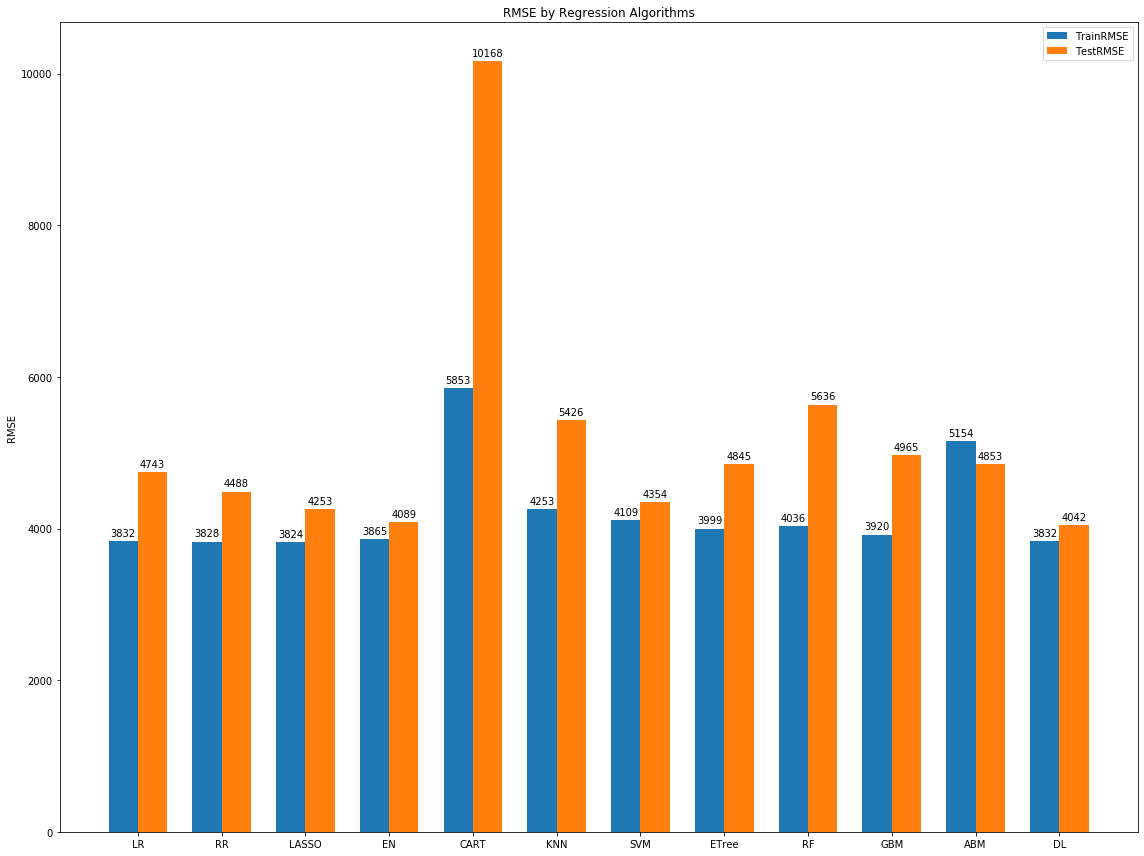

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# Tuning algorithm #1 - ElasticNet
paramGrid1 = dict(alpha=np.array([1,2,3]),l1_ratio=np.array([0.1,0.5,1]),max_iter=np.array([500,1000]))
model1 = ElasticNet(random_state=seedNum,normalize=False)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (math.sqrt(abs(grid_result1.best_score_)), grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('EN')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (math.sqrt(abs(mean)), param))
